In [29]:
# Import necessary libraries
import pandas as pd
from scipy.io import arff

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [30]:
# Import necessary libraries
import pandas as pd
from scipy.io import arff

# Load the ARFF file
file_path = '/Users/haripriyan/Documents/UWM_Sem3/MachineLearning/phishing_websites/Training_Dataset.arff'
data, meta = arff.loadarff(file_path)

# Convert the ARFF data into a pandas DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the dataset
print("Dataset Overview:")
print(df.head())

# Display basic information about the dataset
print("\nDataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Display basic statistics for numeric columns
print("\nBasic Statistics:")
print(df.describe(include='all'))

Dataset Overview:
  having_IP_Address URL_Length Shortining_Service having_At_Symbol  \
0             b'-1'       b'1'               b'1'             b'1'   
1              b'1'       b'1'               b'1'             b'1'   
2              b'1'       b'0'               b'1'             b'1'   
3              b'1'       b'0'               b'1'             b'1'   
4              b'1'       b'0'              b'-1'             b'1'   

  double_slash_redirecting Prefix_Suffix having_Sub_Domain SSLfinal_State  \
0                    b'-1'         b'-1'             b'-1'          b'-1'   
1                     b'1'         b'-1'              b'0'           b'1'   
2                     b'1'         b'-1'             b'-1'          b'-1'   
3                     b'1'         b'-1'             b'-1'          b'-1'   
4                     b'1'         b'-1'              b'1'           b'1'   

  Domain_registeration_length Favicon  ... popUpWidnow Iframe age_of_domain  \
0                  

In [31]:
# Decode byte strings to integers
for column in df.columns:
    df[column] = df[column].apply(lambda x: int(x.decode('utf-8')))

# Check target variable distribution
print("Target Variable Distribution:")
print(df['Result'].value_counts())

# Display the first few rows after decoding
print("\nDataset after Decoding:")
print(df.head())

Target Variable Distribution:
Result
 1    6157
-1    4898
Name: count, dtype: int64

Dataset after Decoding:
   having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0                 -1           1                   1                 1   
1                  1           1                   1                 1   
2                  1           0                   1                 1   
3                  1           0                   1                 1   
4                  1           0                  -1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             

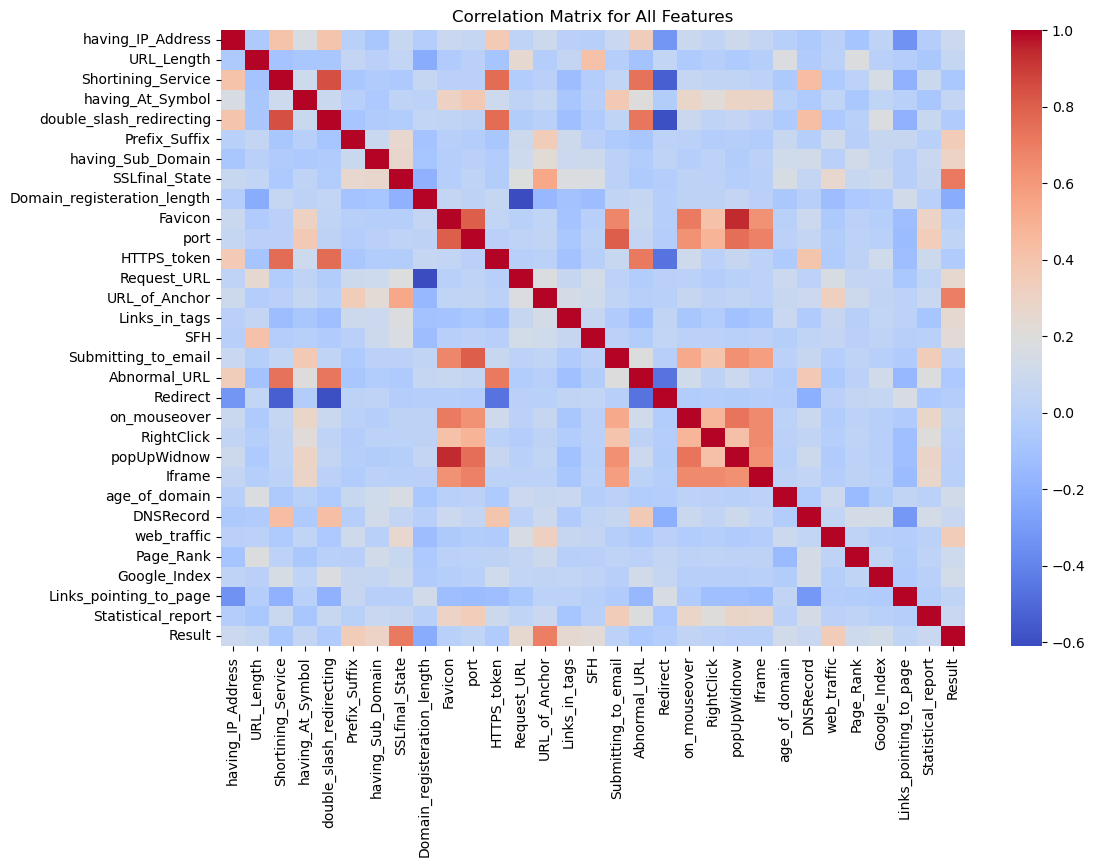

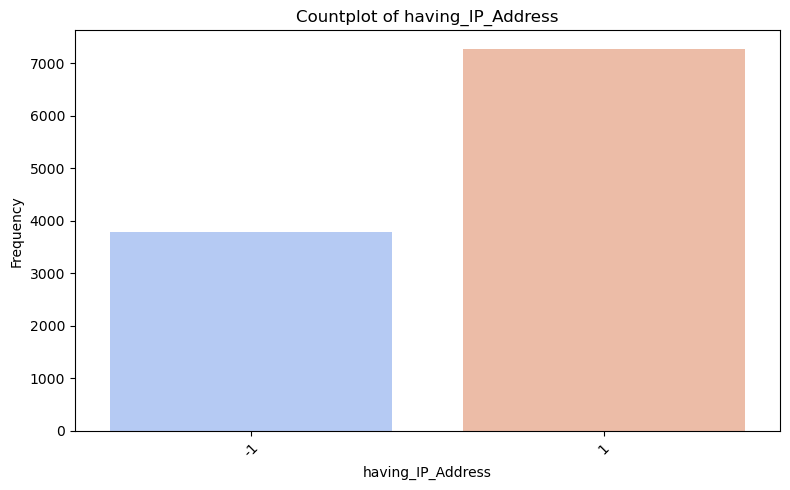

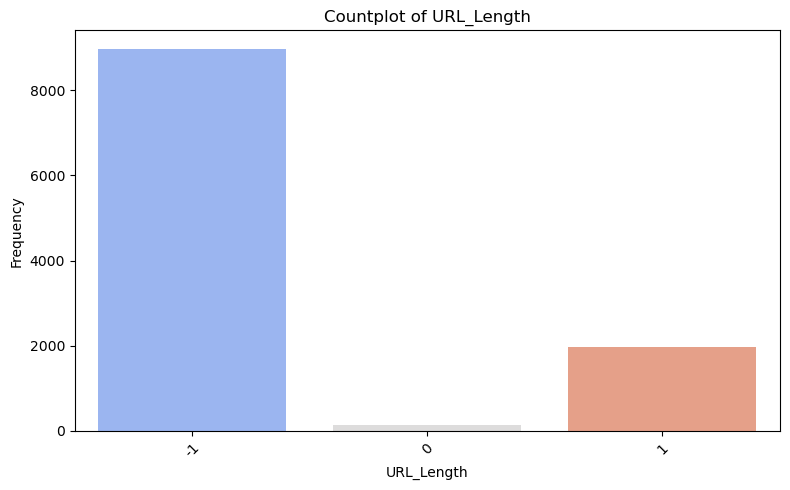

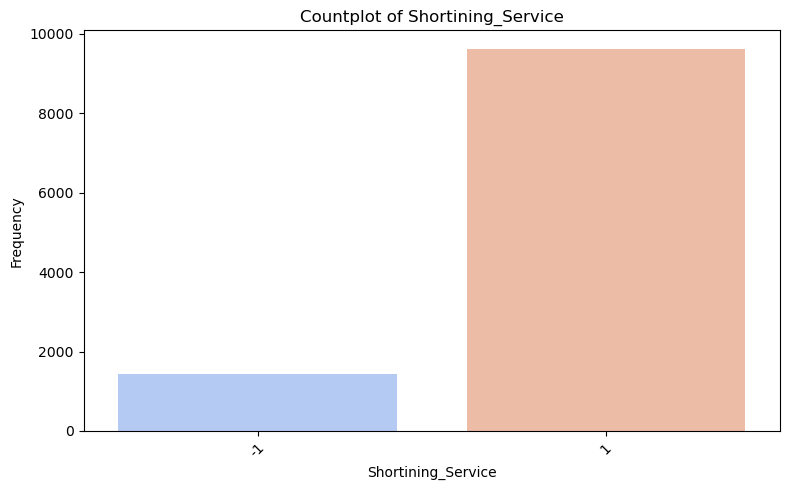

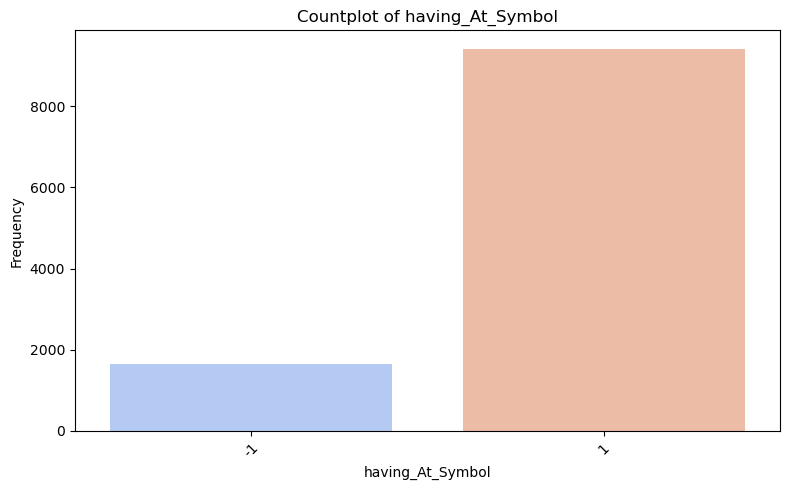

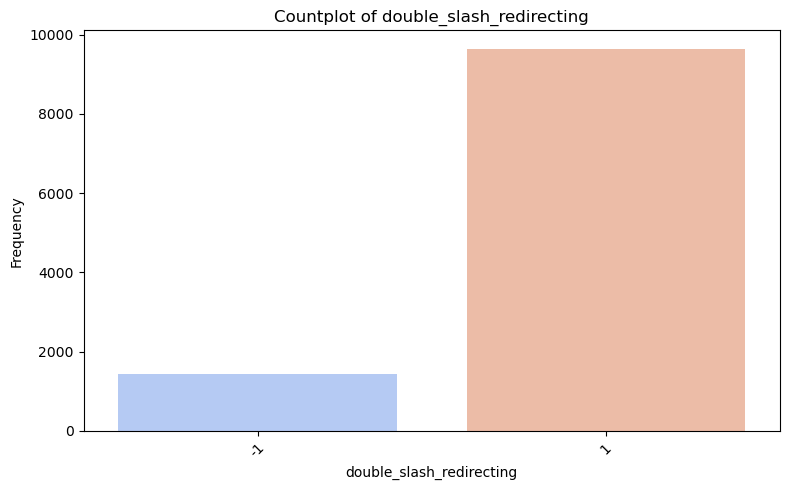

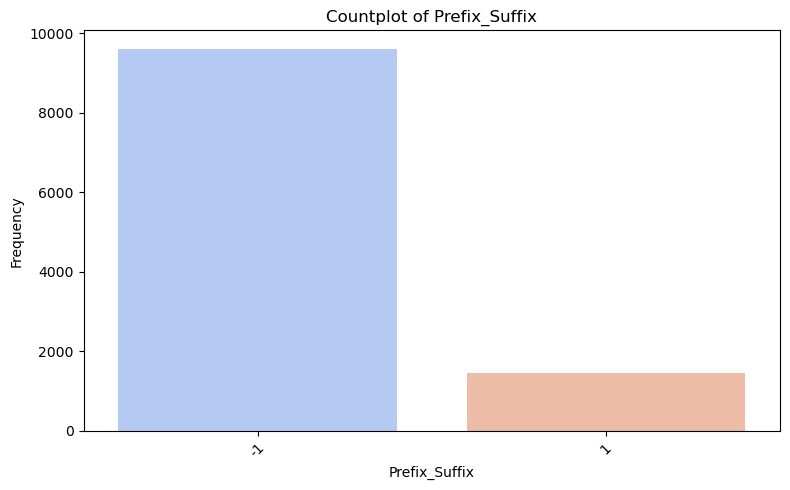

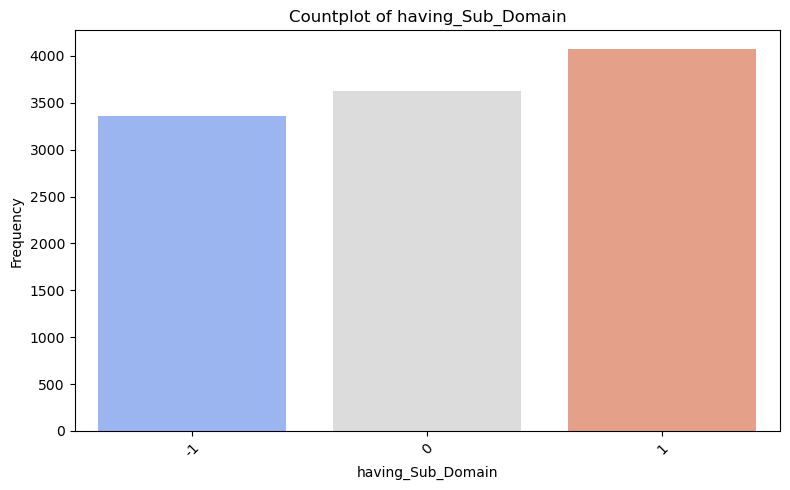

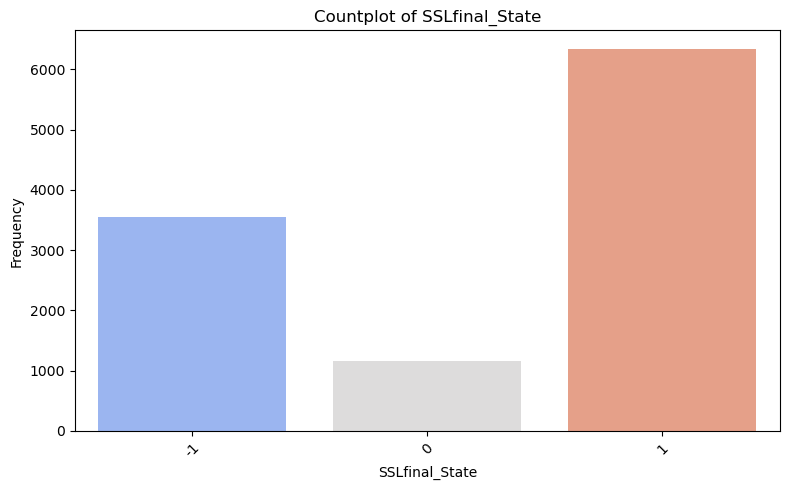

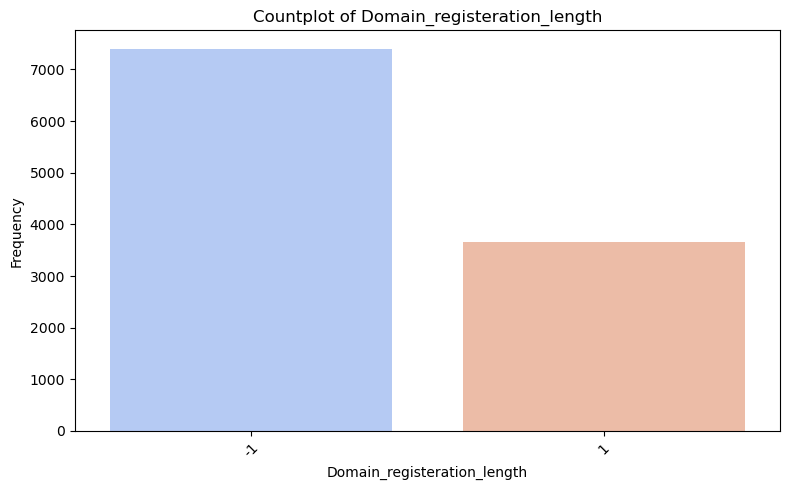

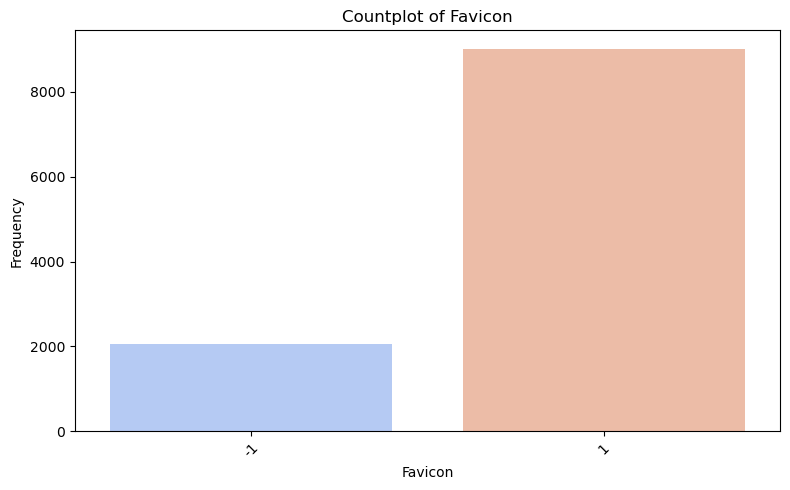

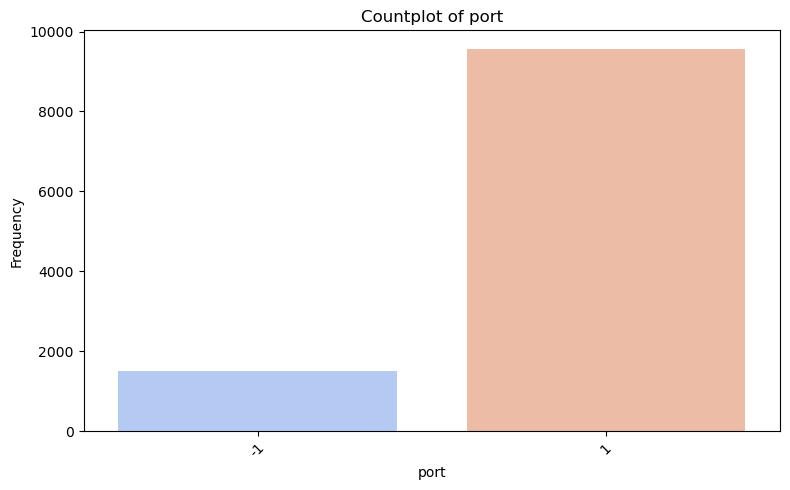

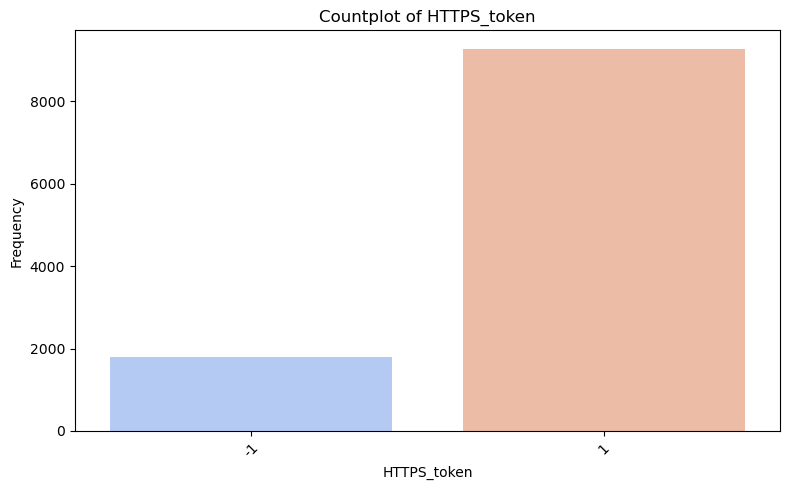

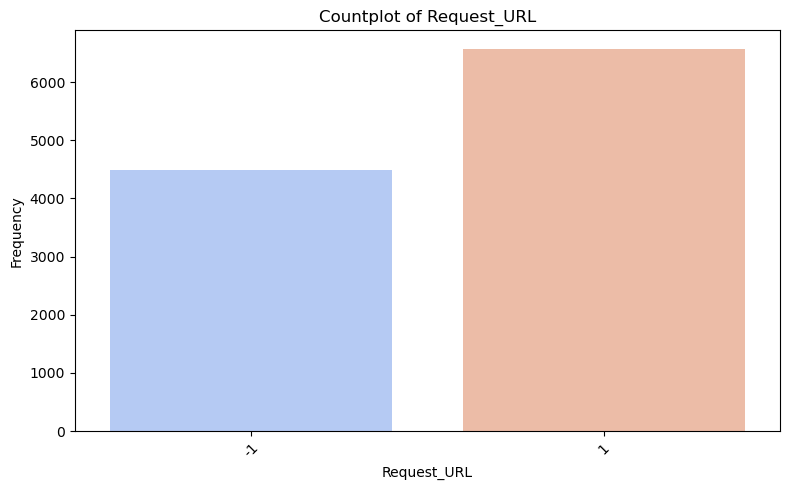

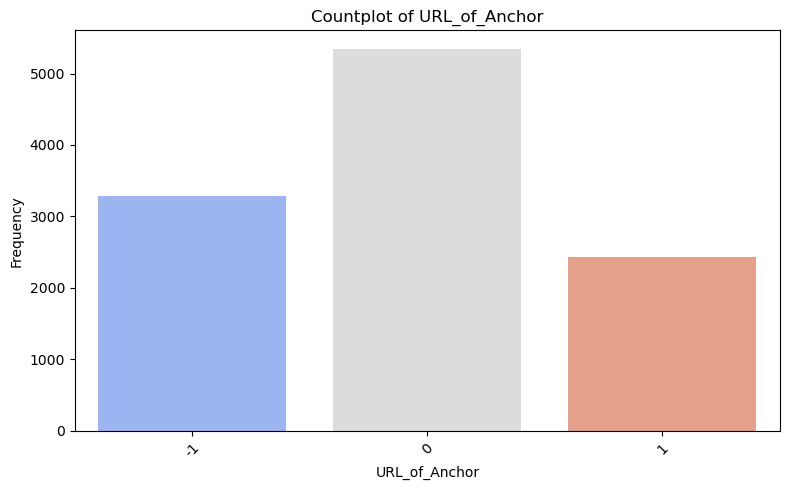

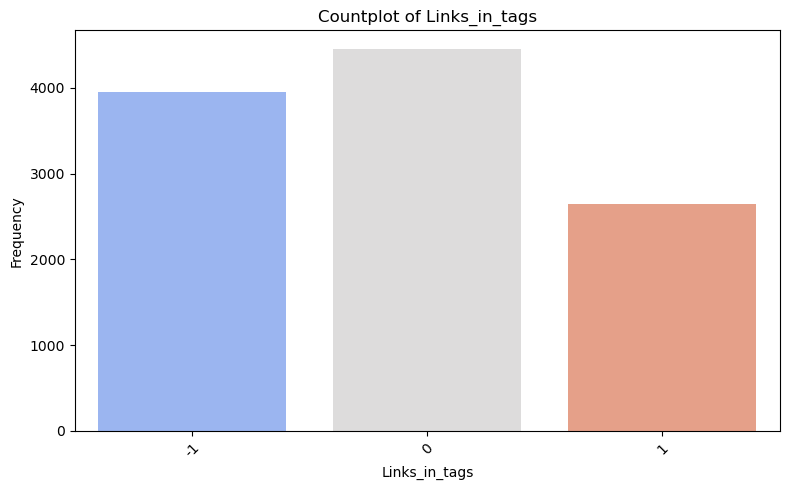

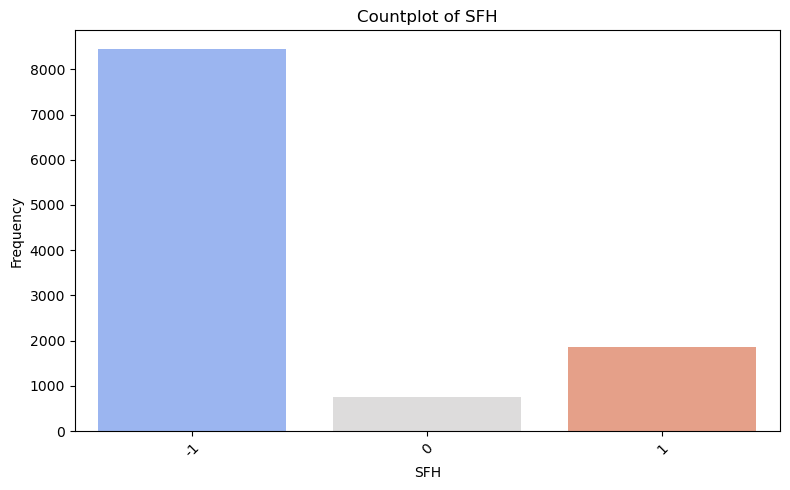

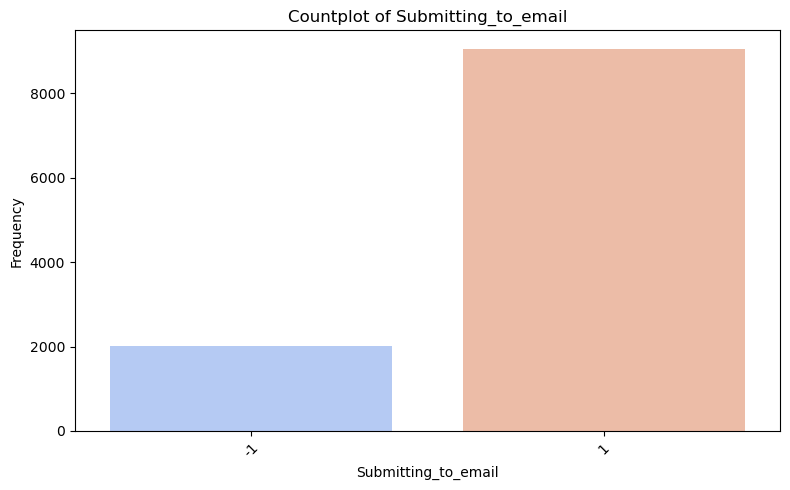

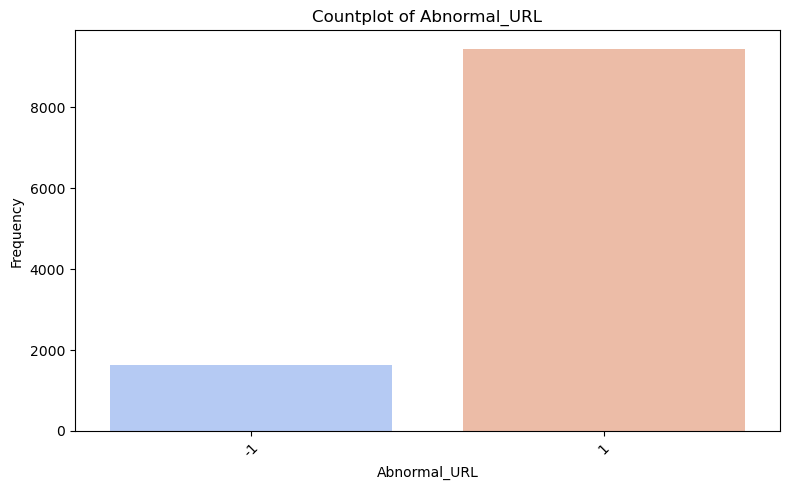

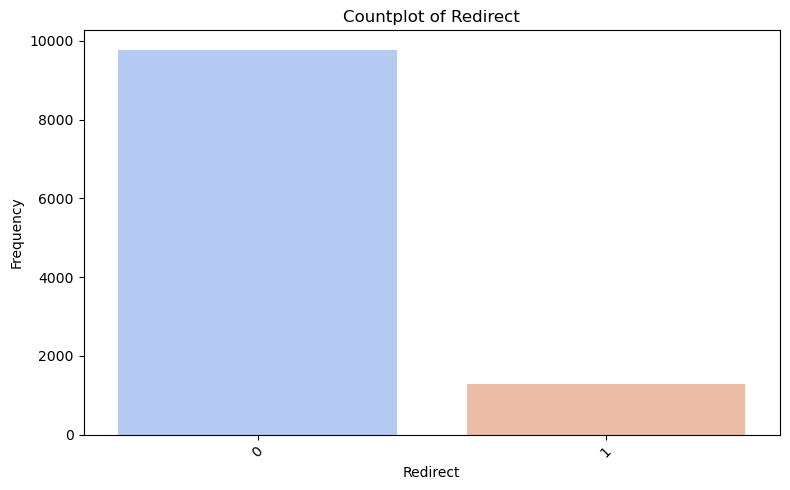

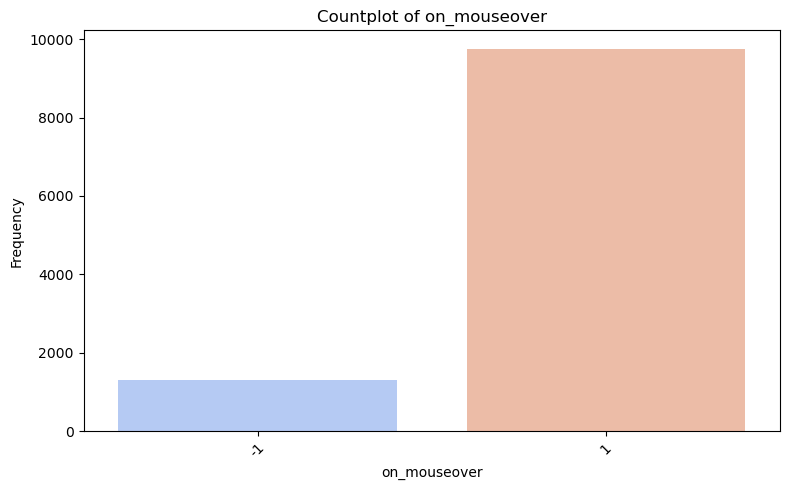

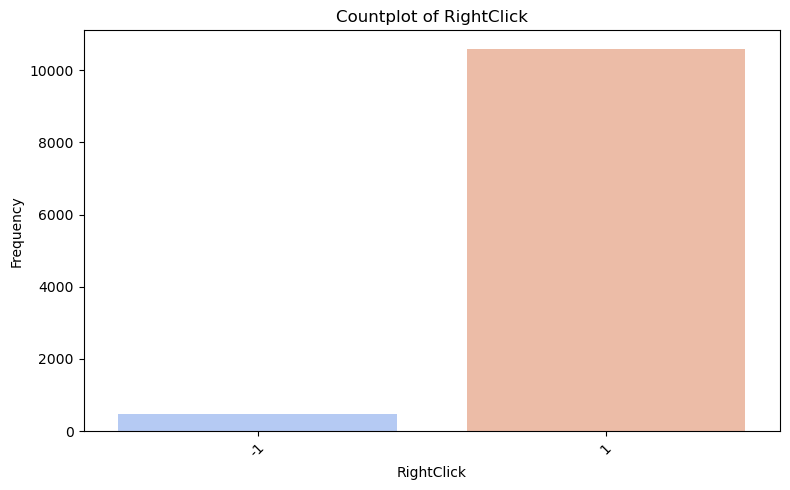

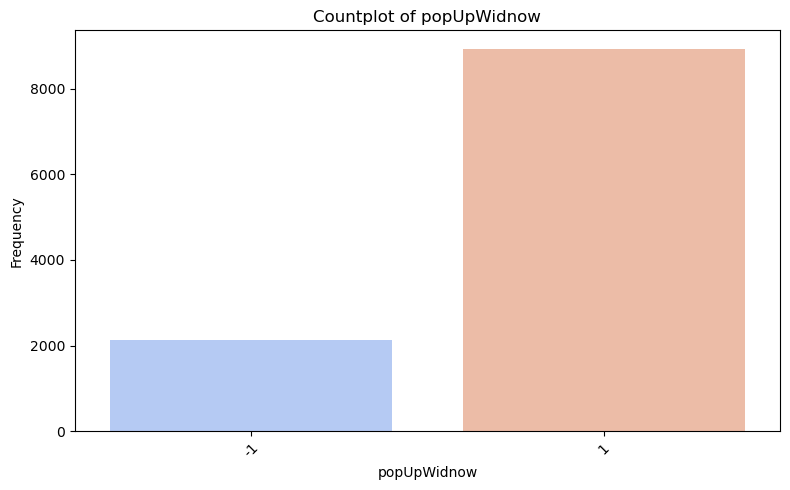

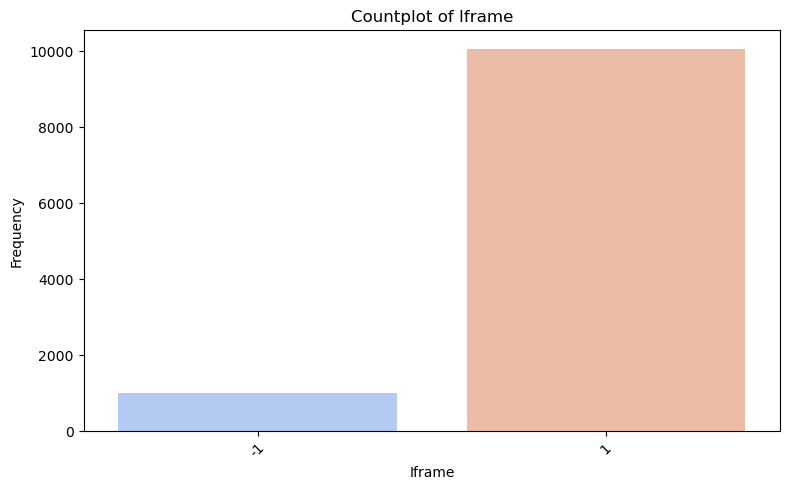

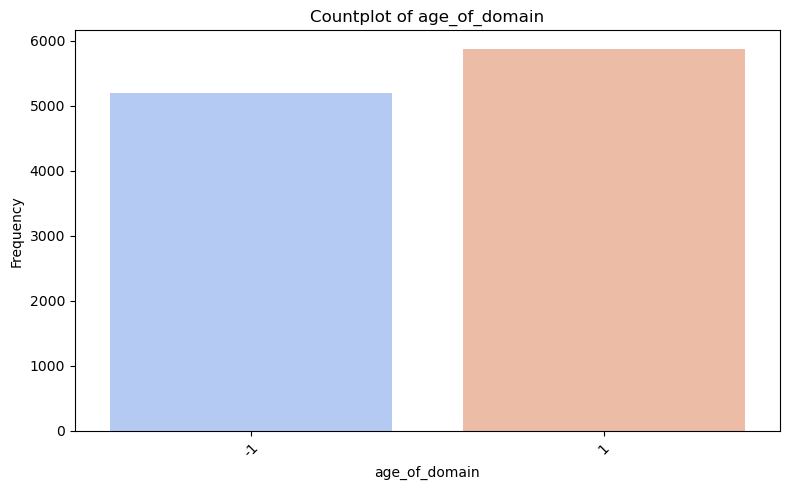

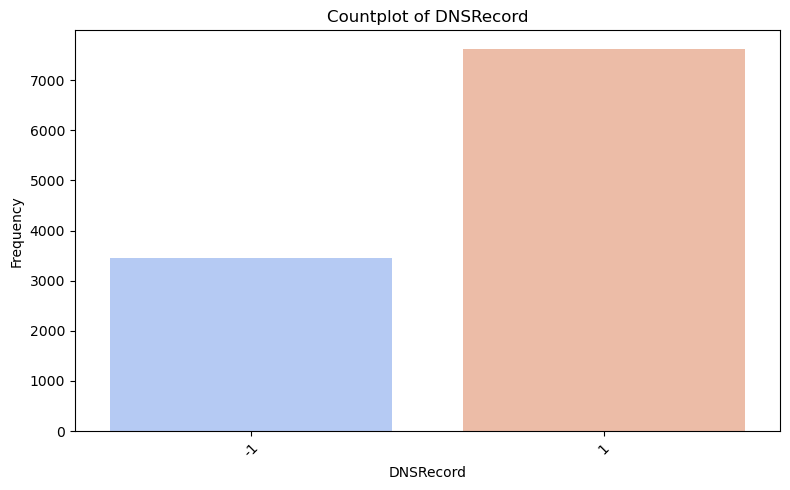

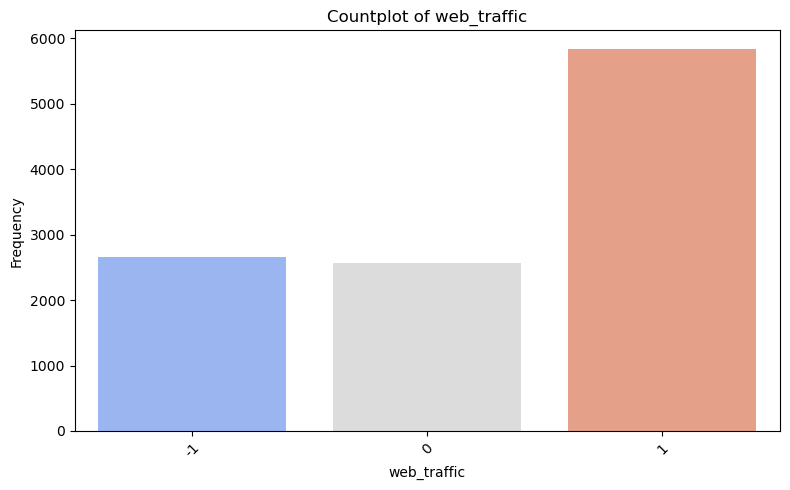

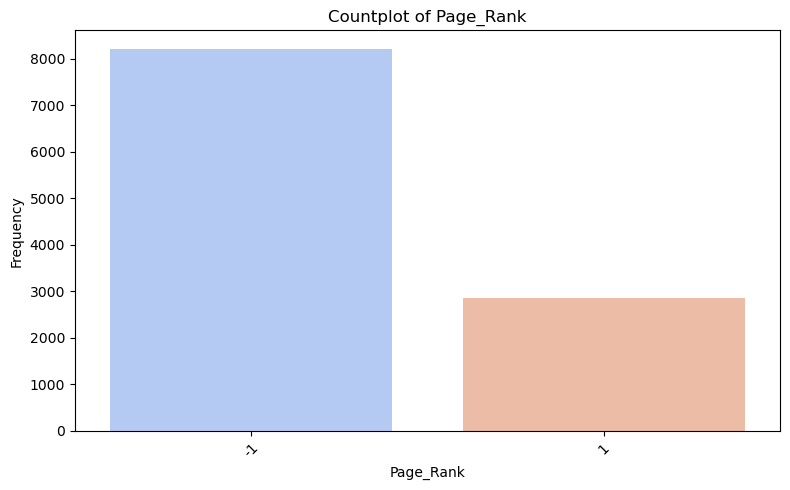

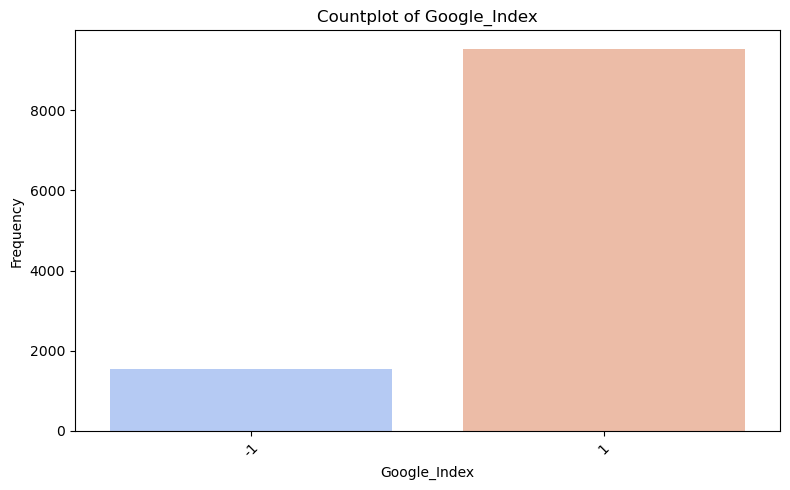

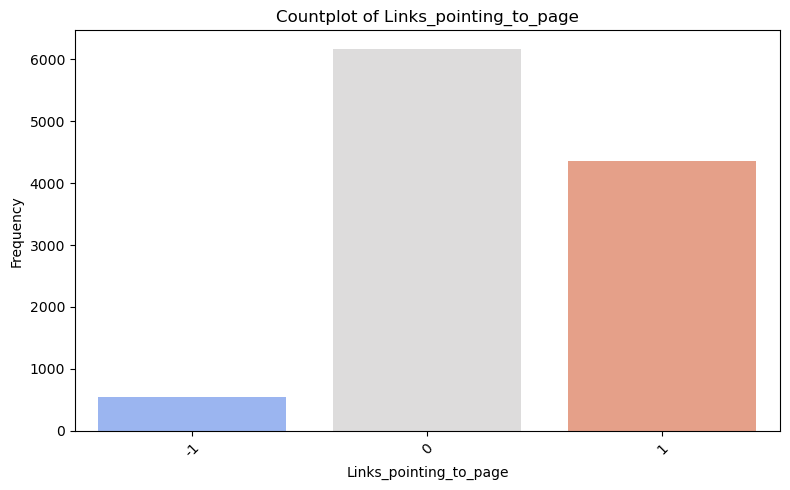

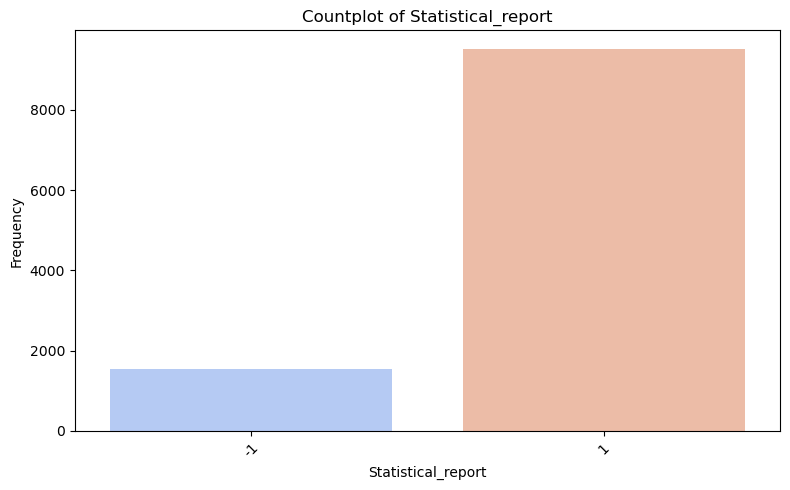

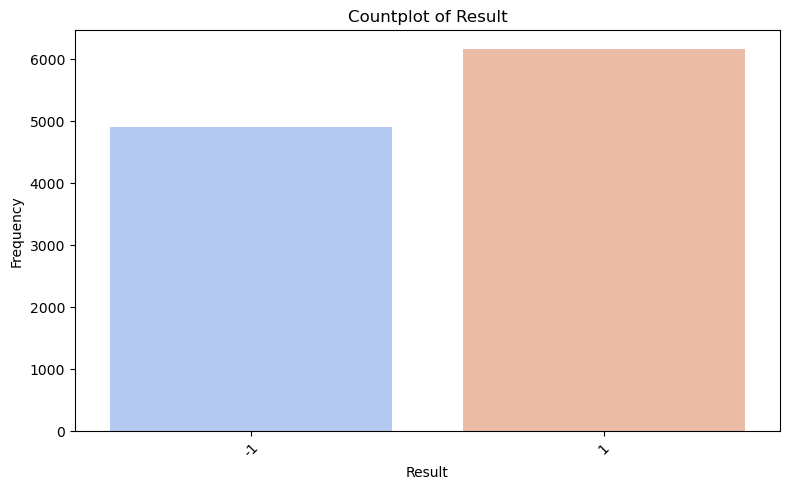

In [32]:
# Assuming df is already prepared (decoded and cleaned) from your previous steps

# 1. Correlation Heatmap for All Features
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for All Features')
plt.show()

# 2. Univariate Analysis for Each Feature (Including Target)
def univariate_analysis(df):
    """
    For each feature in the dataframe, create either a countplot (if few unique values)
    or a histogram (if continuous-like) and display them inline.
    """
    for column in df.columns:
        plt.figure(figsize=(8, 5))

        # Check unique values to decide plot type
        if df[column].nunique() <= 10:
            # Binary or categorical-like features
            sns.countplot(x=column, data=df, palette='coolwarm')
            plt.title(f'Countplot of {column}')
        else:
            # If any continuous features exist, use histogram
            sns.histplot(df[column], kde=True, color='steelblue')
            plt.title(f'Distribution of {column}')

        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Run the univariate analysis
univariate_analysis(df)

In [33]:
# Calculate correlations with the target
target_correlations = df.corr()['Result'].drop('Result')  # exclude the target itself

# Sort features by absolute correlation with the target
top_features = target_correlations.abs().sort_values(ascending=False)

print("Features sorted by absolute correlation with the target:")
print(top_features)

# picking the top 10 features
selected_features = top_features.index[:10].tolist()
print("\nTop 10 selected features:", selected_features)

Features sorted by absolute correlation with the target:
SSLfinal_State                 0.714741
URL_of_Anchor                  0.692935
Prefix_Suffix                  0.348606
web_traffic                    0.346103
having_Sub_Domain              0.298323
Request_URL                    0.253372
Links_in_tags                  0.248229
Domain_registeration_length    0.225789
SFH                            0.221419
Google_Index                   0.128950
age_of_domain                  0.121496
Page_Rank                      0.104645
having_IP_Address              0.094160
Statistical_report             0.079857
DNSRecord                      0.075718
Shortining_Service             0.067966
Abnormal_URL                   0.060488
URL_Length                     0.057430
having_At_Symbol               0.052948
on_mouseover                   0.041838
HTTPS_token                    0.039854
double_slash_redirecting       0.038608
port                           0.036419
Links_pointing_to_page 

In [34]:
selected_features = ['SSLfinal_State', 'URL_of_Anchor', 'Prefix_Suffix', 'web_traffic', 'having_Sub_Domain', 'Request_URL', 'Links_in_tags', 'Domain_registeration_length', 'SFH', 'Google_Index']

/Users/haripriyan/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


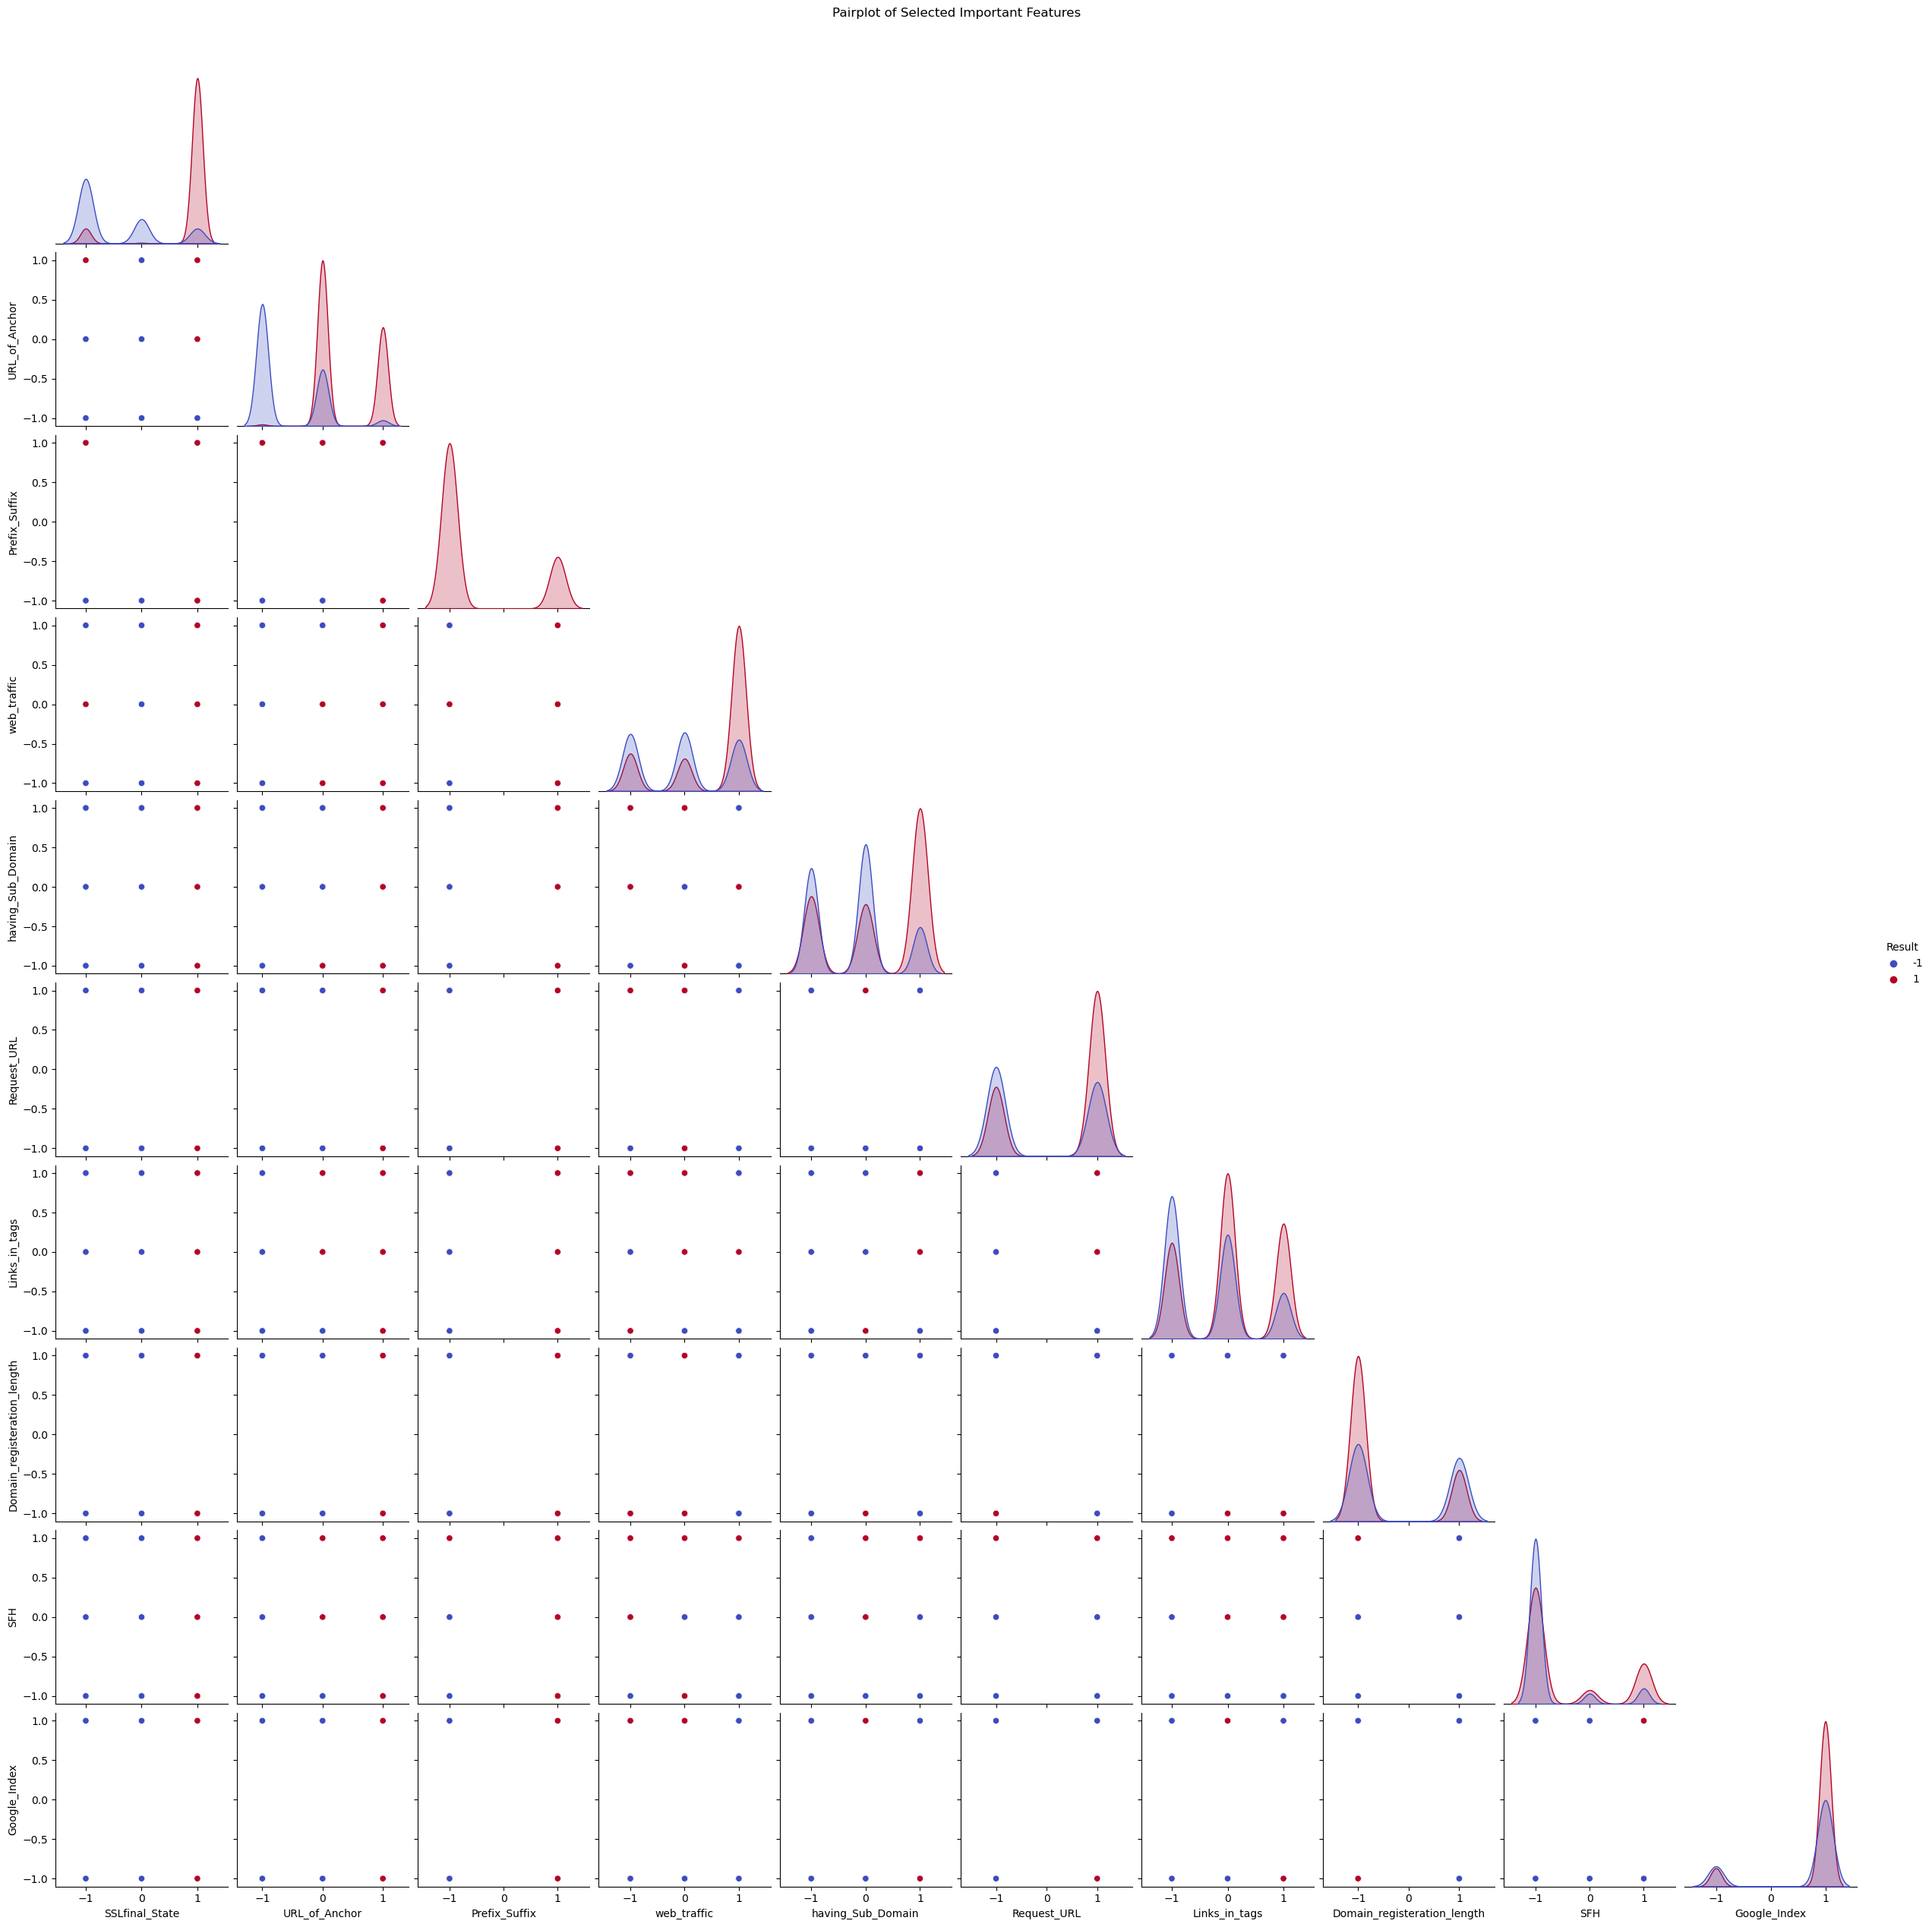

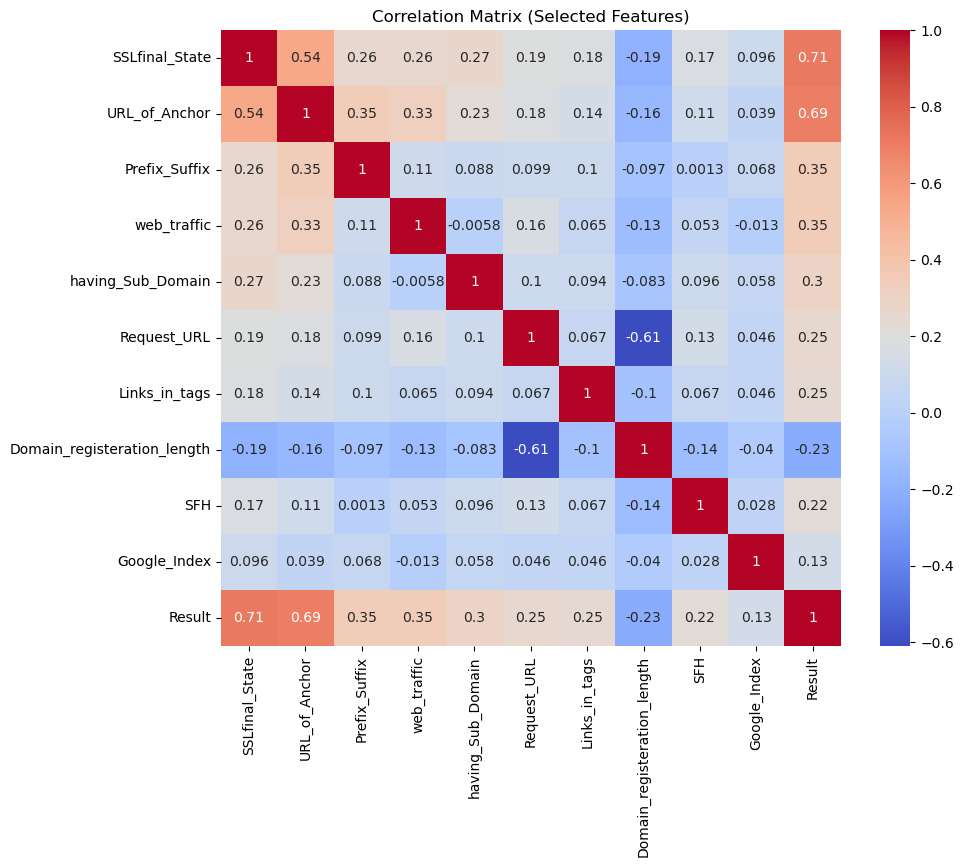

In [35]:
# Create a subset of the dataframe with only selected features + target
focused_df = df[selected_features + ['Result']]

# Pairplot of selected features
sns.pairplot(focused_df, hue='Result', diag_kind='kde', palette='coolwarm', corner=True)
plt.suptitle('Pairplot of Selected Important Features', y=1.02)
plt.show()

# Focused correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix_focused = focused_df.corr()
sns.heatmap(corr_matrix_focused, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix (Selected Features)')
plt.show()


--- LogisticRegression ---
Accuracy: 0.9339665309814563
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       956
           1       0.94      0.95      0.94      1255

    accuracy                           0.93      2211
   macro avg       0.93      0.93      0.93      2211
weighted avg       0.93      0.93      0.93      2211



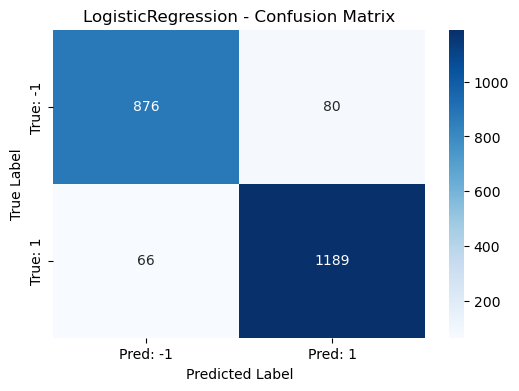

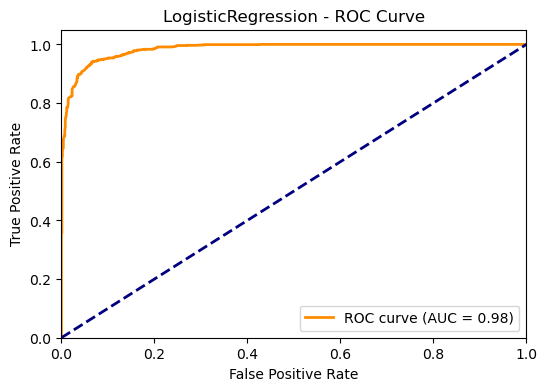

Top 10 Positive Coefficients:
                feature  coefficient
7       Prefix_Suffix_1     2.612312
5       URL_of_Anchor_1     2.583781
2      SSLfinal_State_1     2.544946
4       URL_of_Anchor_0     1.017709
10        web_traffic_1     0.925052
13  having_Sub_Domain_1     0.868884
25       Google_Index_1     0.577416
22                SFH_0     0.526550
17      Links_in_tags_0     0.526213
23                SFH_1     0.364970

Top 10 Negative Coefficients:
                 feature  coefficient
12   having_Sub_Domain_0    -0.431645
11  having_Sub_Domain_-1    -0.437389
24       Google_Index_-1    -0.577566
0      SSLfinal_State_-1    -0.625796
16      Links_in_tags_-1    -0.881541
21                SFH_-1    -0.891670
9          web_traffic_0    -1.223961
1       SSLfinal_State_0    -1.919301
6       Prefix_Suffix_-1    -2.612463
3       URL_of_Anchor_-1    -3.601641

--- RandomForest ---
Accuracy: 0.9425599276345545
Classification Report:
              precision    recall  f1-sc

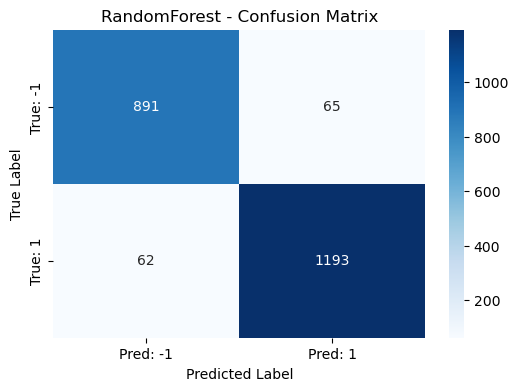

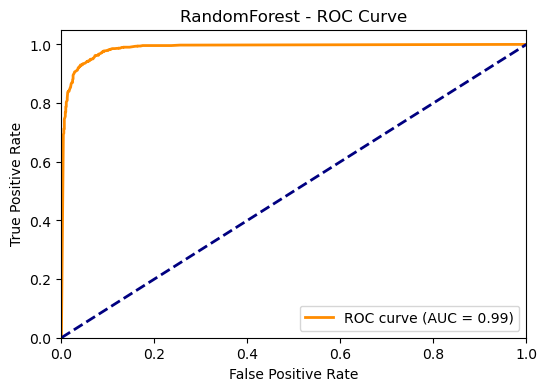

Top 10 Feature Importances:
                feature  importance
2      SSLfinal_State_1    0.274868
3      URL_of_Anchor_-1    0.224425
0     SSLfinal_State_-1    0.090911
5       URL_of_Anchor_1    0.058469
10        web_traffic_1    0.039024
4       URL_of_Anchor_0    0.036093
13  having_Sub_Domain_1    0.033863
1      SSLfinal_State_0    0.033349
6      Prefix_Suffix_-1    0.033066
16     Links_in_tags_-1    0.025471

--- GradientBoosting ---
Accuracy: 0.9434644957033017
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       956
           1       0.95      0.95      0.95      1255

    accuracy                           0.94      2211
   macro avg       0.94      0.94      0.94      2211
weighted avg       0.94      0.94      0.94      2211



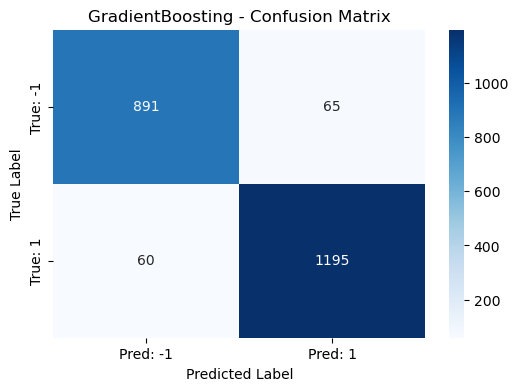

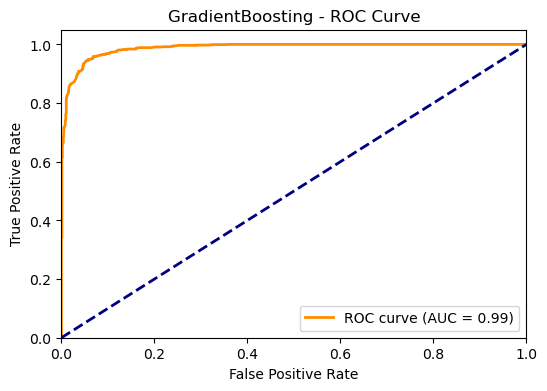

Top 10 Feature Importances:
                feature  importance
2      SSLfinal_State_1    0.716074
3      URL_of_Anchor_-1    0.125160
9         web_traffic_0    0.034864
16     Links_in_tags_-1    0.027546
6      Prefix_Suffix_-1    0.025826
5       URL_of_Anchor_1    0.015574
7       Prefix_Suffix_1    0.012617
13  having_Sub_Domain_1    0.010868
10        web_traffic_1    0.008317
21               SFH_-1    0.005968

--- XGBoost ---
Accuracy: 0.9470827679782904
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       956
           1       0.95      0.96      0.95      1255

    accuracy                           0.95      2211
   macro avg       0.95      0.95      0.95      2211
weighted avg       0.95      0.95      0.95      2211



/Users/haripriyan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


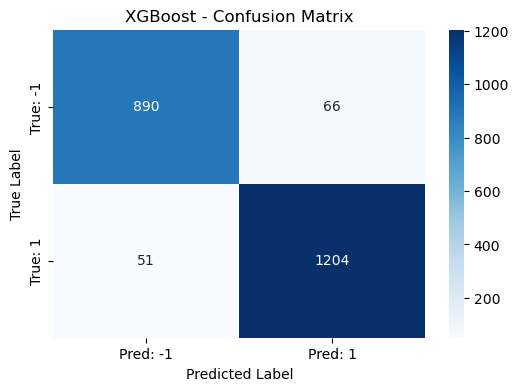

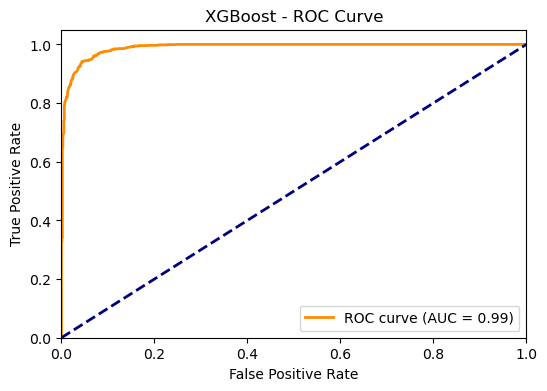

Top 10 Feature Importances:
                feature  importance
2      SSLfinal_State_1    0.568730
3      URL_of_Anchor_-1    0.193914
6      Prefix_Suffix_-1    0.079431
9         web_traffic_0    0.034682
4       URL_of_Anchor_0    0.018022
16     Links_in_tags_-1    0.014785
21               SFH_-1    0.013747
13  having_Sub_Domain_1    0.012133
24      Google_Index_-1    0.007713
5       URL_of_Anchor_1    0.006762

--- SVM ---
Accuracy: 0.9497964721845319
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       956
           1       0.95      0.97      0.96      1255

    accuracy                           0.95      2211
   macro avg       0.95      0.95      0.95      2211
weighted avg       0.95      0.95      0.95      2211



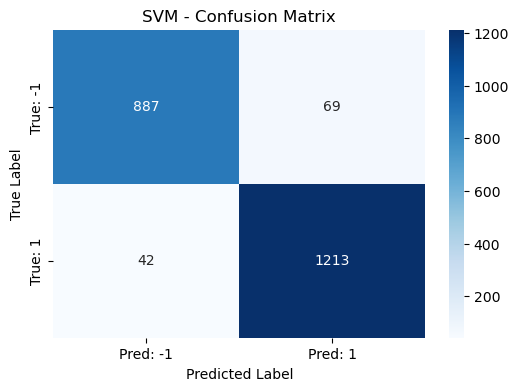

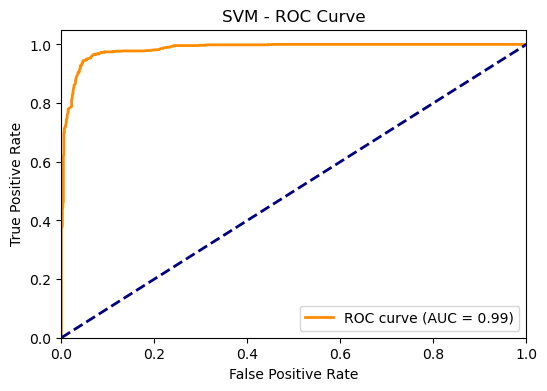


--- KNN ---
Accuracy: 0.9335142469470827
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       956
           1       0.93      0.95      0.94      1255

    accuracy                           0.93      2211
   macro avg       0.93      0.93      0.93      2211
weighted avg       0.93      0.93      0.93      2211



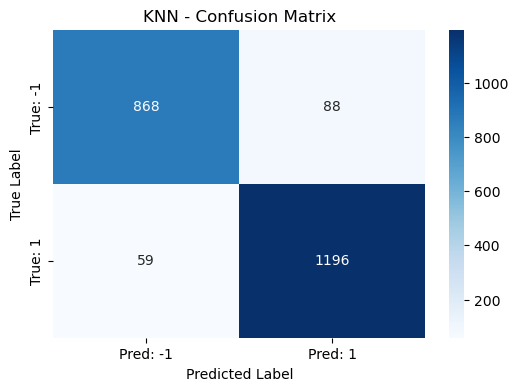

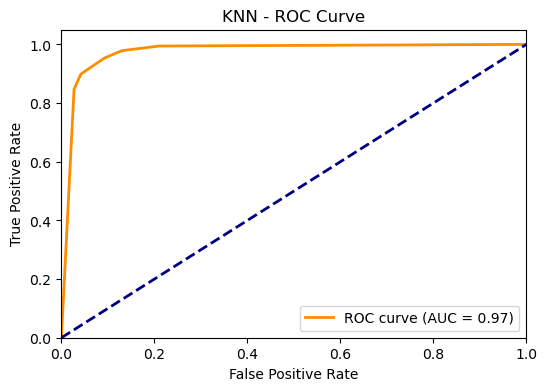


--- NaiveBayes ---
Accuracy: 0.676164631388512
Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       956
           1       1.00      0.43      0.60      1255

    accuracy                           0.68      2211
   macro avg       0.79      0.71      0.66      2211
weighted avg       0.81      0.68      0.66      2211



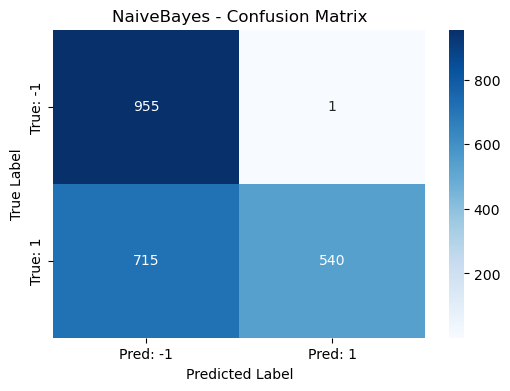

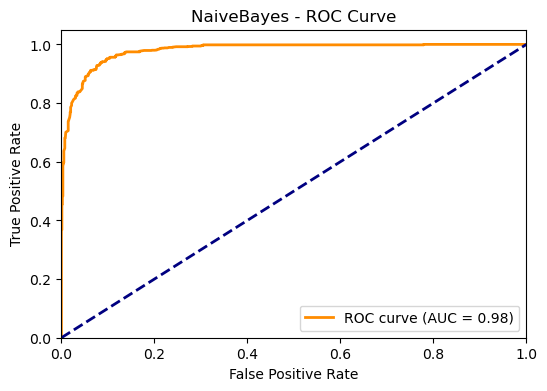

In [36]:
# Assuming df is already cleaned and loaded, with 'Result' as target
# ----------------------------
df['Result'] = df['Result'].map({-1: 0, 1: 1})
X = df[selected_features]
y = df['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# All features are treated as categorical
categorical_cols = X_train.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Defining the Models
# For SVM, we enable probability=True for ROC curve plotting.
# ----------------------------
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'NaiveBayes': GaussianNB()
}

pipelines = {
    name: Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', clf)
    ])
    for name, clf in models.items()
}

# ----------------------------
# Train, Predict, and Visualize Metrics
# ----------------------------
for model_name, pipeline in pipelines.items():
    print(f"\n--- {model_name} ---")
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = pipeline.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Pred: -1','Pred: 1'], 
                yticklabels=['True: -1','True: 1'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # For consistent comparison, we use predict_proba if available
    if hasattr(pipeline.named_steps['classifier'], "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)[:, 1]
    else:
        # Some models like SVC with probability=False don't have predict_proba.
        # With probability=True, we covered it, but just in case:
        if hasattr(pipeline.named_steps['classifier'], "decision_function"):
            y_scores = pipeline.decision_function(X_test)
            # decision_function gives raw scores; for ROC, we treat them as continuous predictions
            y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())  
        else:
            y_proba = None

    if y_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    # Feature Importances (for models that have them)
    if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
        model = pipeline.named_steps['classifier']
        # Get feature names after encoding
        feature_names = pipeline.named_steps['preprocessing'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print("Top 10 Feature Importances:")
        print(feature_importance_df.head(10))
    
    if model_name == 'LogisticRegression' and hasattr(pipeline.named_steps['classifier'], 'coef_'):
        # Coefficients for logistic regression
        model = pipeline.named_steps['classifier']
        feature_names = pipeline.named_steps['preprocessing'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
        coeffs = model.coef_[0]
        
        coeff_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coeffs
        }).sort_values('coefficient', ascending=False)
        
        print("Top 10 Positive Coefficients:")
        print(coeff_df.head(10))
        print("\nTop 10 Negative Coefficients:")
        print(coeff_df.tail(10))

In [37]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Parameter grids for each model
param_grids = {
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': ['scale', 'auto', 0.01, 0.001],
        'classifier__kernel': ['rbf', 'linear']
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.1, 0.01],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0]
    },
    'GradientBoosting': {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__learning_rate': [0.1, 0.01],
        'classifier__max_depth': [3, 5],
        'classifier__subsample': [0.8, 1.0]
    },
    'RandomForest': {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    }
}

# Top performing models identified: SVM, XGBoost, Gradient Boosting, Random Forest
top_models = ['SVM', 'XGBoost', 'GradientBoosting', 'RandomForest']

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tuned_results = {}

for model_name in top_models:
    pipeline = pipelines[model_name]
    param_grid = param_grids[model_name]
    
    print(f"\nTuning hyperparameters for {model_name}...")
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs=-1,
        verbose=2
    )
    
    grid_search.fit(X_train, y_train)
    
    # Store results
    tuned_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_estimator': grid_search.best_estimator_
    }
    
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {grid_search.best_score_:.4f}")

print("\nAll models have been tuned. Please review the best parameters and scores, then share the results.")


Tuning hyperparameters for SVM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for SVM: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best cross-validation accuracy for SVM: 0.9418

Tuning hyperparameters for XGBoost...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/haripriyan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:01:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/haripriyan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:01:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/haripriyan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:01:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/haripriyan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:01:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

Best parameters for XGBoost: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best cross-validation accuracy for XGBoost: 0.9455

Tuning hyperparameters for GradientBoosting...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for GradientBoosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best cross-validation accuracy for GradientBoosting: 0.9449

Tuning hyperparameters for RandomForest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for RandomForest: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation accuracy for RandomForest: 0.9462

All models have been tuned. Please review the best parameters and scores, then share the results.



--- Evaluating Tuned SVM ---
Accuracy: 0.945273631840796
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       956
           1       0.95      0.96      0.95      1255

    accuracy                           0.95      2211
   macro avg       0.95      0.94      0.94      2211
weighted avg       0.95      0.95      0.95      2211



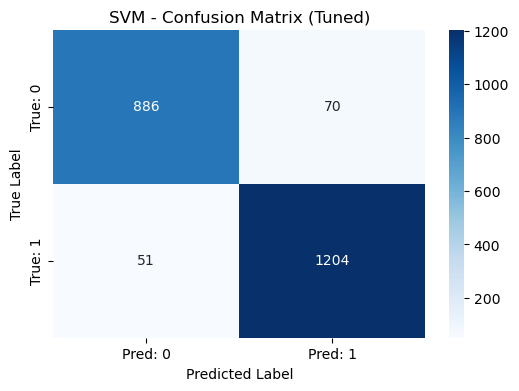

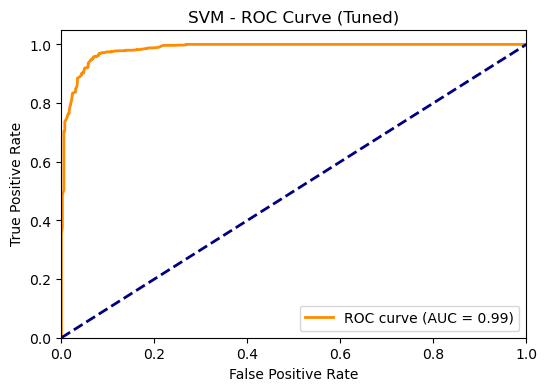


--- Evaluating Tuned XGBoost ---
Accuracy: 0.9484396200814111
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       956
           1       0.95      0.96      0.95      1255

    accuracy                           0.95      2211
   macro avg       0.95      0.95      0.95      2211
weighted avg       0.95      0.95      0.95      2211



/Users/haripriyan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:01:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


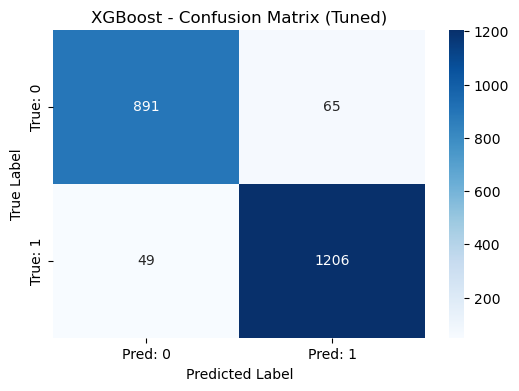

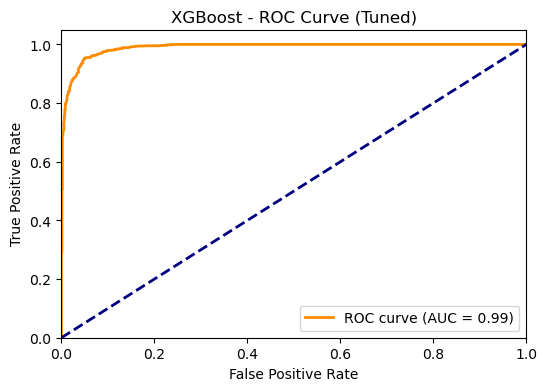


--- Evaluating Tuned GradientBoosting ---
Accuracy: 0.9479873360470376
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       956
           1       0.95      0.96      0.95      1255

    accuracy                           0.95      2211
   macro avg       0.95      0.95      0.95      2211
weighted avg       0.95      0.95      0.95      2211



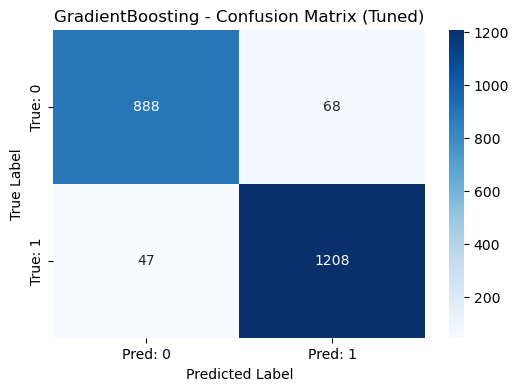

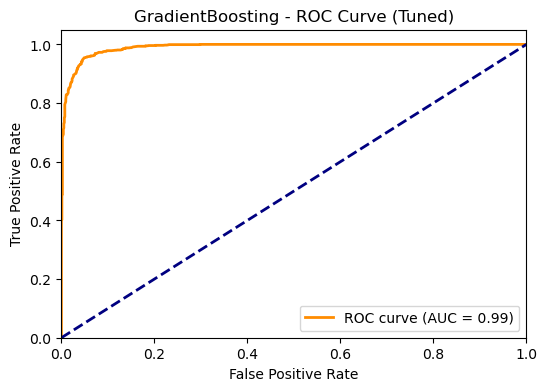


--- Evaluating Tuned RandomForest ---
Accuracy: 0.947535052012664
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       956
           1       0.94      0.96      0.95      1255

    accuracy                           0.95      2211
   macro avg       0.95      0.94      0.95      2211
weighted avg       0.95      0.95      0.95      2211



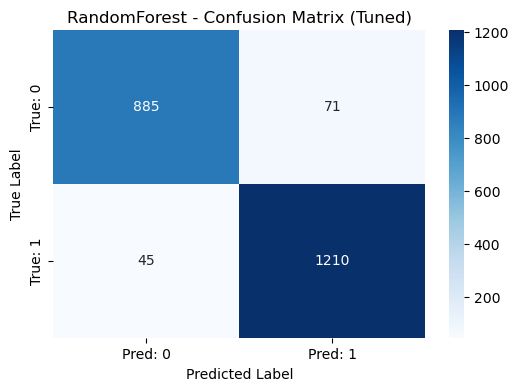

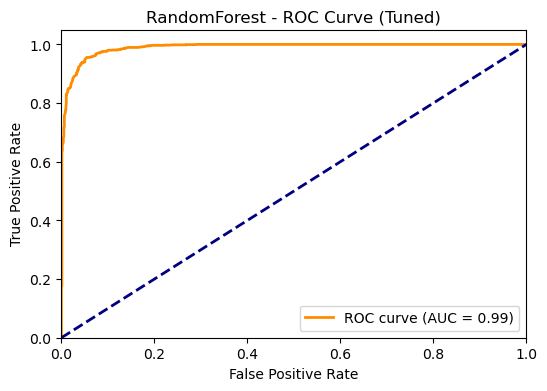

In [38]:
# Assuming df and selected_features are defined, and df['Result'] is already mapped { -1:0, 1:1 }
X = df[selected_features]
y = df['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_cols = X_train.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Create tuned model pipelines
tuned_pipelines = {
    'SVM': Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', SVC(probability=True, random_state=42, 
                           C=10, gamma='scale', kernel='rbf'))
    ]),
    'XGBoost': Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                                     random_state=42, n_estimators=200, max_depth=5,
                                     learning_rate=0.1, subsample=1.0, colsample_bytree=1.0))
    ]),
    'GradientBoosting': Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42,
                                                  n_estimators=100, max_depth=5,
                                                  learning_rate=0.1, subsample=0.8))
    ]),
    'RandomForest': Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42,
                                              n_estimators=200, max_depth=10,
                                              min_samples_split=2))
    ])
}

# Evaluate the tuned models on the test set
for model_name, pipeline in tuned_pipelines.items():
    print(f"\n--- Evaluating Tuned {model_name} ---")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Pred: 0','Pred: 1'], 
                yticklabels=['True: 0','True: 1'])
    plt.title(f'{model_name} - Confusion Matrix (Tuned)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve
    if hasattr(pipeline.named_steps['classifier'], "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)[:, 1]
    else:
        if hasattr(pipeline.named_steps['classifier'], "decision_function"):
            y_scores = pipeline.decision_function(X_test)
            # Normalize scores
            y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())  
        else:
            y_proba = None

    if y_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve (Tuned)')
        plt.legend(loc="lower right")
        plt.show()

Top 10 Feature Importances:
                feature  importance
2      SSLfinal_State_1    0.538629
3      URL_of_Anchor_-1    0.180705
6      Prefix_Suffix_-1    0.066559
9         web_traffic_0    0.042069
4       URL_of_Anchor_0    0.025052
16     Links_in_tags_-1    0.023470
21               SFH_-1    0.017330
13  having_Sub_Domain_1    0.014388
1      SSLfinal_State_0    0.011582
24      Google_Index_-1    0.011236


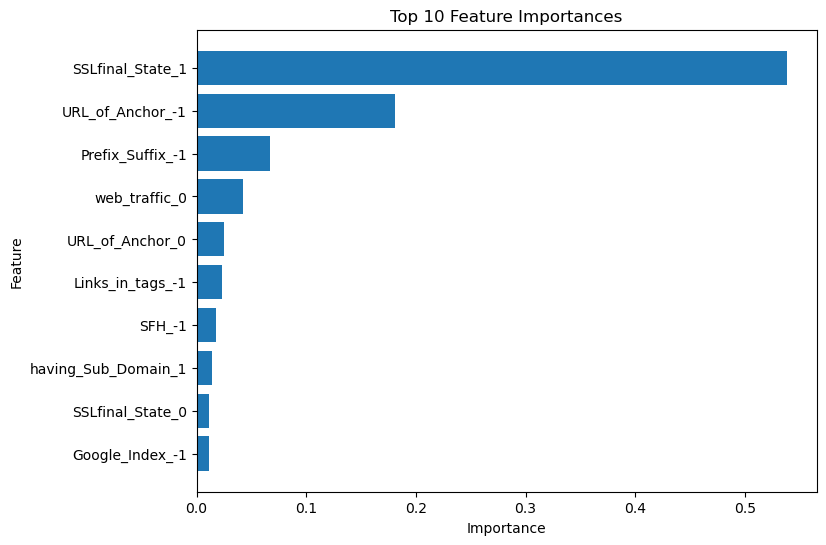

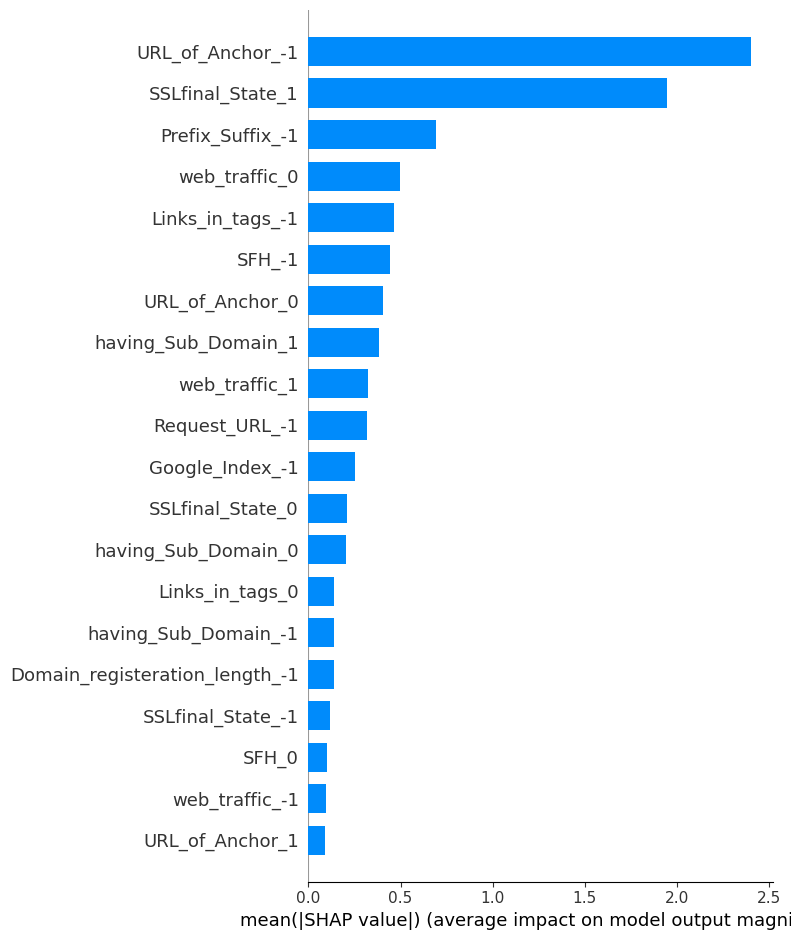

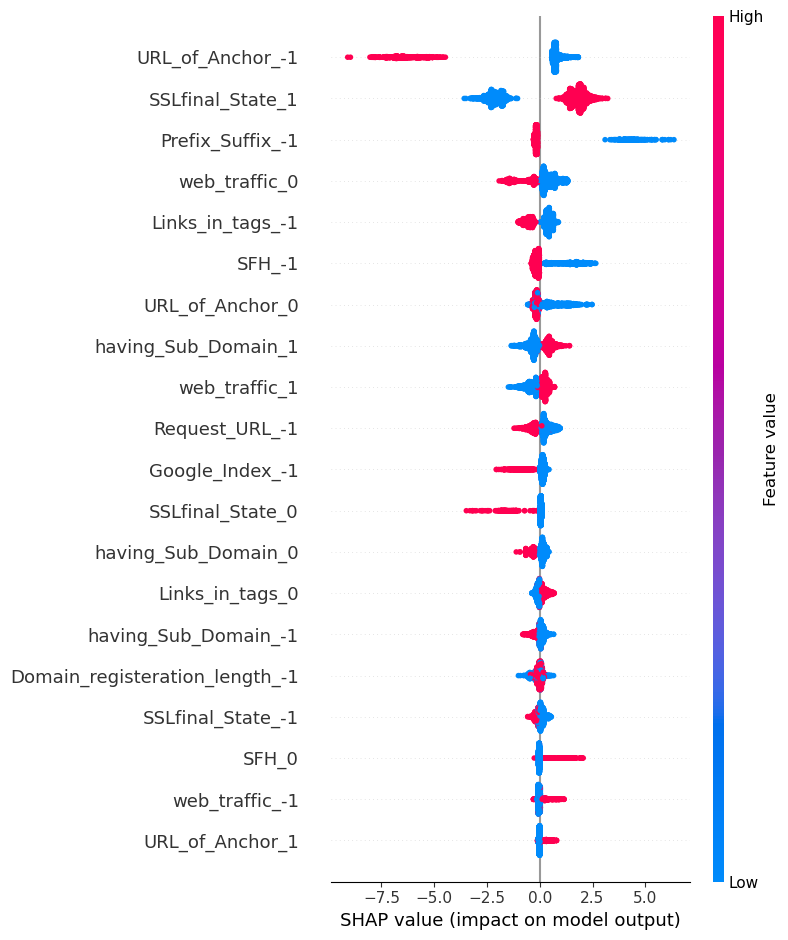

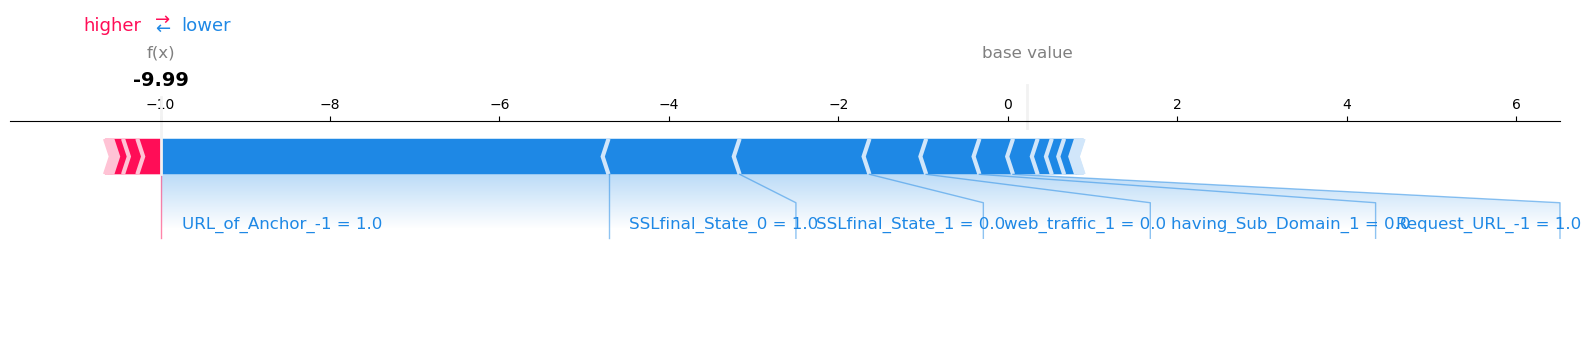

[CV] END classifier__C=0.1, classifier__gamma=scale, classifier__kernel=rbf; total time=   2.3s
[CV] END classifier__C=0.1, classifier__gamma=auto, classifier__kernel=rbf; total time=   2.5s
[CV] END classifier__C=0.1, classifier__gamma=0.01, classifier__kernel=rbf; total time=   3.3s
[CV] END classifier__C=0.1, classifier__gamma=0.001, classifier__kernel=linear; total time=   1.2s
[CV] END classifier__C=1, classifier__gamma=scale, classifier__kernel=rbf; total time=   1.7s
[CV] END classifier__C=1, classifier__gamma=scale, classifier__kernel=rbf; total time=   1.7s
[CV] END classifier__C=1, classifier__gamma=scale, classifier__kernel=linear; total time=   1.4s
[CV] END classifier__C=1, classifier__gamma=auto, classifier__kernel=rbf; total time=   1.7s
[CV] END classifier__C=1, classifier__gamma=auto, classifier__kernel=linear; total time=   1.2s
[CV] END classifier__C=1, classifier__gamma=0.01, classifier__kernel=linear; total time=   1.2s
[CV] END classifier__C=1, classifier__gamma=0

In [39]:
import shap

# Assuming you've chosen the XGBoost model as the final model:
final_model = tuned_pipelines['XGBoost']

# Extract the classifier and preprocessor
preprocessor = final_model.named_steps['preprocessing']
classifier = final_model.named_steps['classifier']

# Get one-hot-encoded feature names
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Compute feature importances (from the classifier)
importances = classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 10 Feature Importances:")
print(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(8,6))
plt.barh(feature_importance_df['feature'][:10][::-1], feature_importance_df['importance'][:10][::-1])
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# ----------------------------
# SHAP Analysis
# ----------------------------

# For SHAP, we need the matrix of transformed features
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Create a SHAP explainer using the tree-based method
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test_transformed)

# Global explanation: Summary plot of feature importance with SHAP
# This shows how features contribute to predictions across multiple samples
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names, plot_type="bar")

# Another summary plot (beeswarm) for a more detailed view
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

# Local explanation for a single instance
index_to_explain = 0  # for example, pick the first test instance
shap.force_plot(explainer.expected_value, shap_values[index_to_explain,:], X_test_transformed[index_to_explain,:], feature_names=feature_names, matplotlib=True)